In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import bayes3d as b3d
import trimesh
import os
from bayes3d._mkl.utils import *
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import jax
from jax import jit, vmap
import jax.numpy as jnp


key = jax.random.PRNGKey(0)

In [4]:
_scaling  = 1e-3
model_dir = os.path.join(b3d.utils.get_assets_dir(),"bop/ycbv/models")

meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    mesh = trimesh.load(mesh_path)
    mesh.vertices *= _scaling 
    meshes.append(mesh)


mesh_path = os.path.join(b3d.utils.get_assets_dir(), "sample_objs/cube.obj")
mesh = trimesh.load(mesh_path)
mesh.vertices *= 1e-1
meshes.append(mesh)


In [5]:
mesh = meshes[1]

print(mesh)
print(mesh.visual)
print("material?", hasattr(mesh.visual, "material"))

if isinstance(mesh.visual, trimesh.visual.color.ColorVisuals):
    texvis = mesh.visual.to_texture()
elif isinstance(mesh.visual, trimesh.visual.texture.TextureVisuals):
    texvis = mesh.visual

assert isinstance(texvis, trimesh.visual.texture.TextureVisuals)

print("material, how about now?", hasattr(texvis, "material"))
print("to_color?", hasattr(texvis.material, "to_color"))

mesh.faces.shape, mesh.vertices.shape, texvis.uv.shape

<trimesh.Trimesh(vertices.shape=(8291, 3), faces.shape=(15728, 3), name=`obj_000002.ply`)>
material? True
material, how about now? True
to_color? True


((15728, 3), (8291, 3), (8291, 2))

In [207]:
def barycentric_to_mesh(p, i, vertices, faces):
    x = jnp.sum(p[:,None]*vertices[faces[i]], axis=0)
    return x


def area_of_triangle(a, b, c=jnp.zeros(3)):
    v = a-c
    w = b-c

    l = jnp.linalg.norm(w)
    h = jnp.linalg.norm(v - jnp.dot(v, w)/l**2*w)
    area = l*h

    return area/2


def _compute_area_and_normal(f, vertices):
    a = vertices[f[1]] - vertices[f[0]]
    b = vertices[f[2]] - vertices[f[0]]
    area = area_of_triangle(a, b)
    normal = jnp.cross(a,b)
    return area, normal


compute_area_and_normals = jit(vmap(_compute_area_and_normal, (0,None)))

In [118]:
areas, normals = compute_area_and_normals(mesh.faces, mesh.vertices)

print(f"""
    mean  area: {areas.mean():0.2e}
    std   area: {areas.std():0.2e}
    total area: {areas.sum():0.4f}
""")


    mean  area: 7.09e-06
    std   area: 2.80e-06
    total area: 0.1115



In [178]:
mesh.faces.shape, mesh.vertices.shape, texvis.uv.shape

((15728, 3), (8291, 3), (8291, 2))

In [199]:
"""
Uniformly sample points on the surface of the mesh.

Args: 
    areas
    faces
    vertices
    uvs
    [to_color]
"""
key, keys = keysplit(key,1,2)
n  = 35_000
fs = jax.random.categorical(keys[0], jnp.log(areas), shape=(n,))
ps = jax.random.dirichlet(keys[1], jnp.ones(3), (n,))
xs = jnp.sum(ps[:,:,None]*mesh.vertices[mesh.faces[fs]], axis=1)
us = jnp.sum(ps[:,:,None]*texvis.uv[mesh.faces[fs]], axis=1)
cs = texvis.material.to_color(us)/255

In [203]:
def uniformly_sample_from_mesh(key, n, faces, vertices, texture_uv=None, uv_to_color=None):
    """Uniformly sample points on the surface from a mesh."""

    key, keys = keysplit(key,1,2)

    areas, _ = compute_area_and_normals(faces, vertices)

    fs = jax.random.categorical(keys[0], jnp.log(areas), shape=(n,))
    ps = jax.random.dirichlet(keys[1], jnp.ones(3), (n,))
    xs = jnp.sum(ps[:,:,None]*vertices[faces[fs]], axis=1)

    if to_color is not None:
        us = jnp.sum(ps[:,:,None]*texture_uv[faces[fs]], axis=1)
        cs = uv_to_color(us)/255
    else:
        cs = None

    return xs, ps, cs

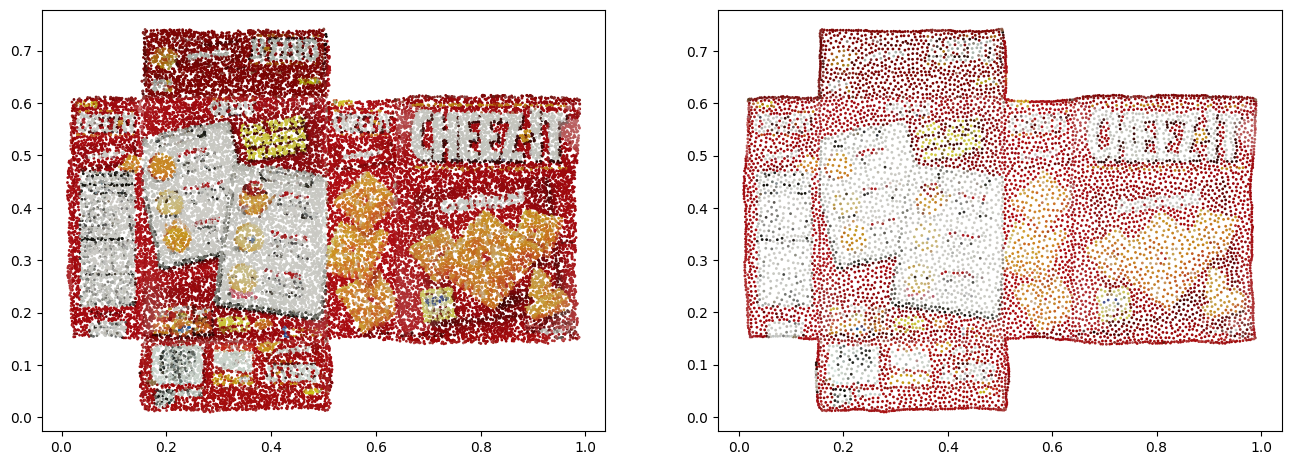

In [198]:
us_ = texvis.uv
cs_ = texvis.material.to_color(us_)/255


# ================================
fig, axs = plt.subplots(1,2, figsize=(16,8))
for ax in axs: ax.set_aspect(1)
axs[0].scatter(*us.T, c=cs, s=1)
axs[1].scatter(*us_.T, c=cs_, s=1)